# Vision Transformer (ViT) for facial image classification based on gender

## Prerequisites
1. Linux OS
2. Conda Environment installed according to the steps from https://github.com/pgagarinov/pytorch-hyperlight/blob/main/products/jupyterlab-ml-devenv/README.md
3. PyTorch-Hyperlight package `pip install pytorch-hyperlight`

In [190]:
import math
import os
import re
import warnings
from abc import abstractmethod
from pathlib import Path

import albumentations as albu
import matplotlib.pyplot as plt
import numpy as np
import pytorch_hyperlight as pth
import pytorch_lightning as pl
import pytorch_pretrained_vit
import torch
import torch.nn.functional as F
import torchvision
from albumentations.pytorch import ToTensor
from efficientnet_pytorch import EfficientNet
from PIL import Image
from pytorch_hyperlight.tasks.classification import AClassificationTask
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

In [2]:
FAST_DEV_RUN = False  # if true, simplifed configurations running for just a few epochs are used for making sure there are no obvious bugs

In [3]:
if "workbookDir" not in globals():
    workbookDir = os.getcwd()

WORKBOOK_DIR = Path(workbookDir)

## Loading data from UTKFace dataset

In [4]:
!kaggle datasets download -d 'jangedoo/utkface-new'

utkface-new.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!unzip -n -q utkface-new.zip

In [63]:
class UTKFaces(Dataset):
    CLASS_LABELS = ["male", "female"]

    def class_inds2labels(class_ind_list):
        label_list = [UTKFaces.CLASS_LABELS[ind] for ind in class_ind_list]
        return label_list

    def class_ind2label(class_ind):
        return UTKFaces.CLASS_LABELS[class_ind]

    def __init__(self, file_list, labels, transform=None):
        self._file_list = file_list
        self._labels = np.array(labels, dtype=np.int64)
        self._transform = transform

    def __len__(self):
        return len(self._file_list)

    def __getitem__(self, idx):
        img_path = self._file_list[idx]
        img = Image.open(img_path)
        if self._transform:
            img_transformed = self._transform(image=np.array(img))["image"]
        else:
            img_transformed = img

        id_label = self._labels[idx]
        return img_transformed, id_label

In [7]:
EXPERIMENT_ID = "vit-utk-faces"

In [8]:
DATASETS_PATH = WORKBOOK_DIR / "UTKFace"

In [9]:
SEED = 16

In [10]:
IMAGE_SIZE = 200

In [11]:
warnings.filterwarnings("ignore")

We use [Albumentations](https://github.com/albumentations-team/albumentations) library to for image data augmentation

In [12]:
NORMALIZE_MEAN_LIST = (0.485, 0.456, 0.406)
NORMALIZE_STD_LIST = (0.229, 0.224, 0.225)

In [13]:
NORMALIZE_T = albu.Normalize(NORMALIZE_MEAN_LIST, NORMALIZE_STD_LIST)

In [14]:
BORDER_CONSTANT = 0
BORDER_REFLECT = 2


def pre_transforms(image_size=IMAGE_SIZE):
    # Convert the image to a square of size image_size x image_size
    # (keeping aspect ratio)
    result = [
        albu.LongestMaxSize(max_size=image_size),
        albu.PadIfNeeded(image_size, image_size, border_mode=BORDER_CONSTANT),
    ]

    return result


def hard_transforms():
    result = [
        # Random shifts, stretches and turns with a 50% probability
        albu.ShiftScaleRotate(
            shift_limit=0.1,
            scale_limit=0.1,
            rotate_limit=15,
            border_mode=BORDER_REFLECT,
            p=0.5,
        ),
        albu.IAAPerspective(scale=(0.02, 0.05), p=0.3),
        # Random brightness / contrast with a 30% probability
        albu.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
        # Random gamma changes with a 30% probability
        albu.RandomGamma(gamma_limit=(85, 115), p=0.3),
        # Randomly changes the hue, saturation, and color value of the input image
        albu.HueSaturationValue(p=0.3),
        albu.JpegCompression(quality_lower=80),
    ]

    return result


def show_transforms():
    return [ToTensor()]


def post_transforms():
    # we use ImageNet image normalization
    # and convert it to torch.Tensor
    return [NORMALIZE_T, ToTensor()]


def compose(transforms_to_compose):
    # combine all augmentations into one single pipeline
    result = albu.Compose(
        [item for sublist in transforms_to_compose for item in sublist]
    )
    return result

We will create a special `show_dataset` along with the standard `train`, `val` and `test` datasets. `show_dataset` doesn't contain data normalization so that the pictures remain visible

In [15]:
# a dedicated function for creating datasets
# please note how 'full_train_dataset' is created along with train,
# val and test datasets
def create_datasets(val_size=0.2, test_size=0.05):
    pl.seed_everything(SEED)
    all_file_name_list = list(DATASETS_PATH.glob("*.jpg"))
    age_list, gender_list, etnicity_list = zip(
        *[
            re.split("_", cur_file.name, maxsplit=3)[:3]
            for cur_file in all_file_name_list
        ]
    )
    TRANSFORM_DICT = {
        "train": compose([pre_transforms(), hard_transforms(), post_transforms()]),
        "val": compose([pre_transforms(), post_transforms()]),
        "show_augmented": compose(
            [pre_transforms(), hard_transforms(), show_transforms()]
        ),
        "inference": compose([post_transforms()]),
        "show": compose([show_transforms()]),
    }
    #
    label_vec = np.array(gender_list)
    all_file_name_vec = np.array(all_file_name_list)

    n_classes = len(np.unique(label_vec))

    ind_all_vec = np.arange(len(label_vec))
    np.random.shuffle(ind_all_vec)

    n_full_train_samples = len(ind_all_vec)
    n_val_samples = int(n_full_train_samples * val_size)
    n_test_samples = int(n_full_train_samples * test_size)
    ind_train_vec, ind_val_vec, ind_test_vec = np.split(
        ind_all_vec,
        np.cumsum(
            [
                n_full_train_samples - n_val_samples - n_test_samples,
                n_val_samples,
            ]
        ),
    )

    full_train_dataset = UTKFaces(
        all_file_name_vec, label_vec, transform=TRANSFORM_DICT["train"]
    )

    show_augmented_full_train_dataset = UTKFaces(
        all_file_name_vec, label_vec, transform=TRANSFORM_DICT["show_augmented"]
    )

    inference_test_dataset = UTKFaces(
        all_file_name_vec[ind_test_vec],
        label_vec[ind_test_vec],
        transform=TRANSFORM_DICT["inference"],
    )

    show_test_dataset = UTKFaces(
        all_file_name_vec[ind_test_vec],
        label_vec[ind_test_vec],
        transform=TRANSFORM_DICT["show"],
    )

    train_dataset = UTKFaces(
        all_file_name_vec[ind_train_vec],
        label_vec[ind_train_vec],
        transform=TRANSFORM_DICT["train"],
    )
    val_dataset = UTKFaces(
        all_file_name_vec[ind_val_vec],
        label_vec[ind_val_vec],
        transform=TRANSFORM_DICT["val"],
    )
    test_dataset = UTKFaces(
        all_file_name_vec[ind_test_vec],
        label_vec[ind_test_vec],
        transform=TRANSFORM_DICT["val"],
    )

    return {
        "full_train_dataset": full_train_dataset,
        "train_dataset": train_dataset,
        "val_dataset": val_dataset,
        "test_dataset": test_dataset,
        "show_augmented_full_train_dataset": show_augmented_full_train_dataset,
        "inference_test_dataset": inference_test_dataset,
        "show_test_dataset": show_test_dataset,
        "n_classes": n_classes,
    }

In [16]:
# a dedicated function for creating dataloaders
# 'full_train_loader' is created along with standard 3 loaderers
# for training, validation and testing datasets
def configure_dataloaders(batch_size, n_workers=4):
    #
    SHUFFLE = True
    SAMPLER = None
    #
    result_dict = create_datasets()
    #
    for prefix in ["train", "full_train"]:

        result_dict[f"{prefix}_loader"] = DataLoader(
            result_dict[f"{prefix}_dataset"],
            batch_size=batch_size,
            shuffle=SHUFFLE,
            sampler=SAMPLER,
            num_workers=n_workers,
            pin_memory=True,
        )
    #
    for prefix in ["val", "test"]:
        result_dict[f"{prefix}_loader"] = DataLoader(
            result_dict[f"{prefix}_dataset"],
            batch_size=batch_size,
            shuffle=False,
            num_workers=n_workers,
            pin_memory=True,
        )

    return result_dict

Let us look at the data after all the data augmentation transformations

In [17]:
BATCH_SIZE = 32

loaders_dict = configure_dataloaders(BATCH_SIZE)

loaders_dict

batch = next(iter(loaders_dict["test_loader"]))
assert len(batch[0]) > 0

Global seed set to 16


In [18]:
dataset_dict = create_datasets()

Global seed set to 16


In [19]:
def create_subplots(n_graphs, figsize=None, max_cols=2):
    if max_cols is not None:
        n_cols = min(n_graphs, max_cols)
    else:
        n_cols = n_graphs

    n_rows = math.ceil(n_graphs / n_cols)
    fig = plt.figure(figsize=figsize)
    ax_list = [None] * n_graphs
    for i_graph in range(n_graphs):
        ax_list[i_graph] = fig.add_subplot(n_rows, n_cols, i_graph + 1)
    return fig, ax_list

In [300]:
def show_image_tensors(
    image_tensor_list, title_list=None, max_cols=None, figsize=None, cmap="viridis"
):
    SUBPLOT_WIDTH = 10
    SUBPLOT_HEIGHT = 10

    if isinstance(image_tensor_list, torch.Tensor):
        image_tensor_list = [image_tensor_list]
    n_images = len(image_tensor_list)
    if max_cols is not None:
        n_cols = min(n_images, max_cols)
    else:
        n_cols = n_images

    n_rows = math.ceil(n_images / n_cols)

    if figsize is None:
        figsize = (SUBPLOT_WIDTH, SUBPLOT_HEIGHT * n_rows / n_cols)

    _, ax_list = create_subplots(n_images, max_cols=max_cols, figsize=figsize)

    for i_image in range(0, n_images):
        ax = ax_list[i_image]
        image_tensor = image_tensor_list[i_image]
        if image_tensor.ndim == 4:
            image_tensor = image_tensor.squeeze(0)
        image_tensor = image_tensor.permute(1, 2, 0)
        ax.imshow(image_tensor, cmap=cmap)
        ax.axis("off")
        if title_list is not None:
            title = title_list[i_image]
            ax.set_title(title)
    plt.show()

In [21]:
show_augmented_full_train_dataset = loaders_dict["show_augmented_full_train_dataset"]

In [22]:
random_sample_vec = np.random.choice(len(show_augmented_full_train_dataset), 10)

In [23]:
img_list, class_ind_list = zip(
    *[show_augmented_full_train_dataset[ind] for ind in random_sample_vec]
)

In [64]:
label_list = UTKFaces.class_inds2labels(class_ind_list)

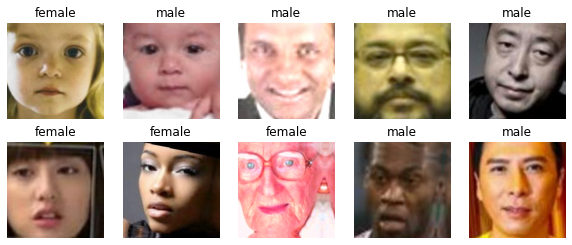

In [65]:
show_image_tensors(img_list, title_list=label_list, max_cols=5)

In [27]:
def show_class_imbalance(dataset_dict):
    fig, ax = plt.subplots(1, figsize=(10, 7))
    plt_list = []
    title_list = []
    dataset_name_len_list = [
        [k, len(v)] for k, v in dataset_dict.items() if isinstance(v, Dataset)
    ]

    for dataset_field, dataset_len in dataset_name_len_list:

        unique_labels, unique_counts = np.unique(
            loaders_dict[dataset_field]._labels, return_counts=True
        )
        unique_labels = class_id_to_label(unique_labels)
        plt_obj = ax.bar(unique_labels, unique_counts)
        plt_list.append(plt_obj)
        title_list.append(f"{dataset_field}: {dataset_len}")

    plt.title("Class Frequency")
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.legend(plt_list, title_list)
    plt.show()

In [28]:
dataset_dict = create_datasets()

Global seed set to 16


Let us see well-balanced our classes are

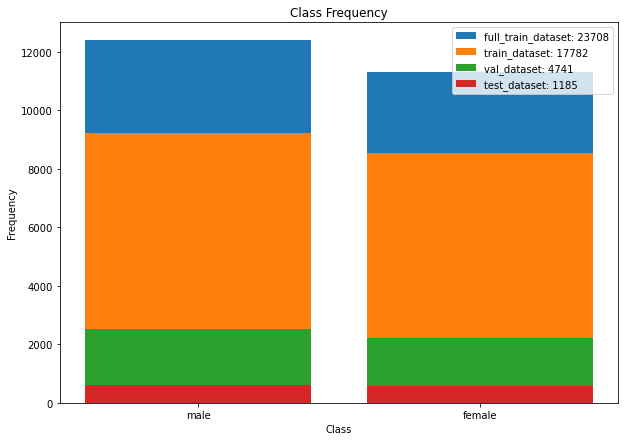

In [29]:
show_class_imbalance(
    {
        k: v
        for k, v in dataset_dict.items()
        if not (k.startswith("inference") or k.startswith("show"))
    }
)

As we can see, the classes are well-balanced which means we can safely use accuracy as a model quality metrics.

### Vision Transformer vs EfficientNet

Let us use our training set to fine-tune both Vision Transformer "B_16_imagenet1k" (which is pretrained on "ImageNet-21k" and fine-tuned on "ImageNet-1k") from [PyTorch-Pretrained-ViT](https://github.com/lukemelas/PyTorch-Pretrained-ViT) GitHub project and EfficientNet-B7 from [EfficientNet-PyTorch](https://github.com/lukemelas/EfficientNet-PyTorch) GitHub project.

We'll use a double-layered FC classification head with biases initialized with zeros to make sure we do not introduce any unnecessary bias to the transformers heads. Dropout between the layeres should help with overfitting.

In [30]:
class FCClassifier(nn.Module):
    def __init__(self, n_features, n_classes, dropout):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.classifier0 = nn.Linear(n_features, n_features)
        self.classifier1 = nn.Linear(n_features, n_classes)
        #
        self.classifier0.weight.data.normal_(mean=0.0, std=0.02)
        self.classifier0.bias.data.zero_()
        self.classifier1.weight.data.normal_(mean=0.0, std=0.02)
        self.classifier1.bias.data.zero_()

    def forward(self, pooled_output):

        pooled_output = self.classifier0(pooled_output)
        pooled_output = F.relu(pooled_output)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier1(pooled_output)
        return logits

Since we will compare Vision Transformer and EfficientNet under the same settings we can safely use the same metrics calculation logic, criterions and optimizers. All this is mostly implemented in a reusable `AClassificationTask` class imported from PyTorch-Hyperlight. The more specific logic (like configuring optimizers) is implemented in `AFineTunedClassifier` class

In [31]:
class AFineTunedClassifier(AClassificationTask):
    def __init__(self, hparams, model):
        criterion = nn.CrossEntropyLoss()
        classifier_module_name = self._get_classifier_module_name()
        old_classifier = getattr(model, classifier_module_name)
        new_classifier = self._build_classifier(hparams, old_classifier.in_features)
        setattr(model, classifier_module_name, new_classifier)
        super().__init__(hparams, model, criterion)

    @abstractmethod
    def _get_classifier_module_name(self):
        pass

    def configure_optimizers(self):
        classifier_prefix = self._get_classifier_module_name() + "."

        classifier_param_list = [
            param
            for name, param in self.model.named_parameters()
            if name.startswith(classifier_prefix)
        ]
        assert len(classifier_param_list) > 0

        rest_param_list = [
            param
            for name, param in self.model.named_parameters()
            if not name.startswith(classifier_prefix)
        ]

        optimizer = optim.Adam(
            [
                {"params": classifier_param_list, "lr": self.hparams.classifier_lr},
                {"params": rest_param_list, "lr": self.hparams.rest_lr},
            ]
        )
        scheduler = optim.lr_scheduler.StepLR(
            optimizer,
            step_size=self.hparams.step_lr_step_size,
            gamma=self.hparams.step_lr_gamma,
        )
        return [optimizer], [scheduler]

    def _build_classifier(self, hparams, n_features):
        n_classes = hparams["n_classes"]
        fc_dropout = hparams["fc_dropout"]
        fc_dropout = hparams["fc_dropout"]
        fc = FCClassifier(n_features, n_classes, fc_dropout)
        return fc

In [32]:
N_CLASSES = loaders_dict["n_classes"]
IS_CUDA = torch.cuda.is_available()
GPU_PER_TRIAL = 0.3 * IS_CUDA

We use batch size = 16 for both compared models. In fact, ViT allows for maximum batch size = 32 for this particular task and RTX 2070 8Gb GPU with 16bit precision. The maximum batch size for EfficientNet on the same hardware is 16. However we do not want the batch size to be different for different models as it might impact model performance.

In [33]:
CONFIG = {
    "classifier_lr": 1e-3,
    "rest_lr": 1e-5,
    "step_lr_gamma": 0.6,
    "step_lr_step_size": 1,
    "fc_dropout": 0.2,
    # "warmup": 500,  # For LinearSchedulerWihtWarmup
    "gradient_clip_val": 2,
    "max_epochs": 10,  # the actual number can be less due to early stopping
    "batch_size": 16,
    "n_classes": N_CLASSES,
}

EXTRA_CONFIG = {
    "seed": SEED,  # just remove this if you do not want determenistic behavior
    "metric_to_optimize": "val_f1_epoch",  # Ray + PTL Trainer
    "ray_metrics_to_show": [
        "val_loss_epoch",
        "val_f1_epoch",
        "val_acc_epoch",
    ],  # for Ray Tune
    "metric_opt_mode": "max",  # Ray + PTL Trainer
    "cpu_per_trial": 3,  # Ray + DataLoaders
    "gpu_per_trial": GPU_PER_TRIAL,  # for Ray Tune
    "n_checkpoints_to_keep": 1,  # for Ray Tune
    "grace_period": 0,  # for both PTL Trainer and Ray Tune scheduler
    "epoch_upper_limit": 45,  # for Ray Tune
    "n_samples": 3,  # for Ray Tune
    "ptl_early_stopping_patience": 3,  # for PTL Trainer
    "ptl_precision": 16,  # or 16, for PTL Trainer
    "train_loader_name": "train_loader",
    "val_loader_name": "val_loader",
    "test_loader_name": "test_loader",
    "batch_size_main": CONFIG[
        "batch_size"
    ],  # batch size for revalidation and test phases
    #    that run in the main process after all Ray Tune child processes are finished
    "gpus": -1 * IS_CUDA,  # -1 - use GPU if available, 0 - use CPU, 1 - use single GPU,
    # >=2 - use multiple GPUs
}

if FAST_DEV_RUN:
    CONFIG["max_epochs"] = 2
    EXTRA_CONFIG["n_samples"] = 2

The `Runner` class from PyTorch-Hyperlight hides all the technicalities related to training, validation and testing of the model. 

In [33]:
runner = pth.Runner(
    configure_dataloaders,
    is_debug=FAST_DEV_RUN,
    experiment_id=EXPERIMENT_ID,
    log2wandb=False,
)

We will use `run_single_trial` method of `Runner` to run a single `trial` i.e a single cycle of training-validation-testing. Please note that we do not pass an instance of our PyTorch-Lightning module into `Runner`. Instead we just pass a class name of our model and let `Runner` instantiate the module by itself.

### EfficientNet-B7 fine-tuning

In [70]:
class EfficientNetClassifier(AFineTunedClassifier):
    def __init__(self, hparams):
        model_name = hparams["model_name"]
        model = EfficientNet.from_pretrained(model_name)
        super().__init__(hparams, model)

    def _get_classifier_module_name(self):
        return "_fc"

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
Global seed set to 16
Global seed set to 16


Loaded pretrained weights for efficientnet-b7


Global seed set to 16

  | Name              | Type             | Params
-------------------------------------------------------
0 | model             | EfficientNet     | 70.3 M
1 | criterion         | CrossEntropyLoss | 0     
2 | train_metric_calc | LitMetricsCalc   | 0     
3 | val_metric_calc   | LitMetricsCalc   | 0     
4 | test_metric_calc  | LitMetricsCalc   | 0     
-------------------------------------------------------
70.3 M    Trainable params
0         Non-trainable params
70.3 M    Total params


Validation sanity check: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

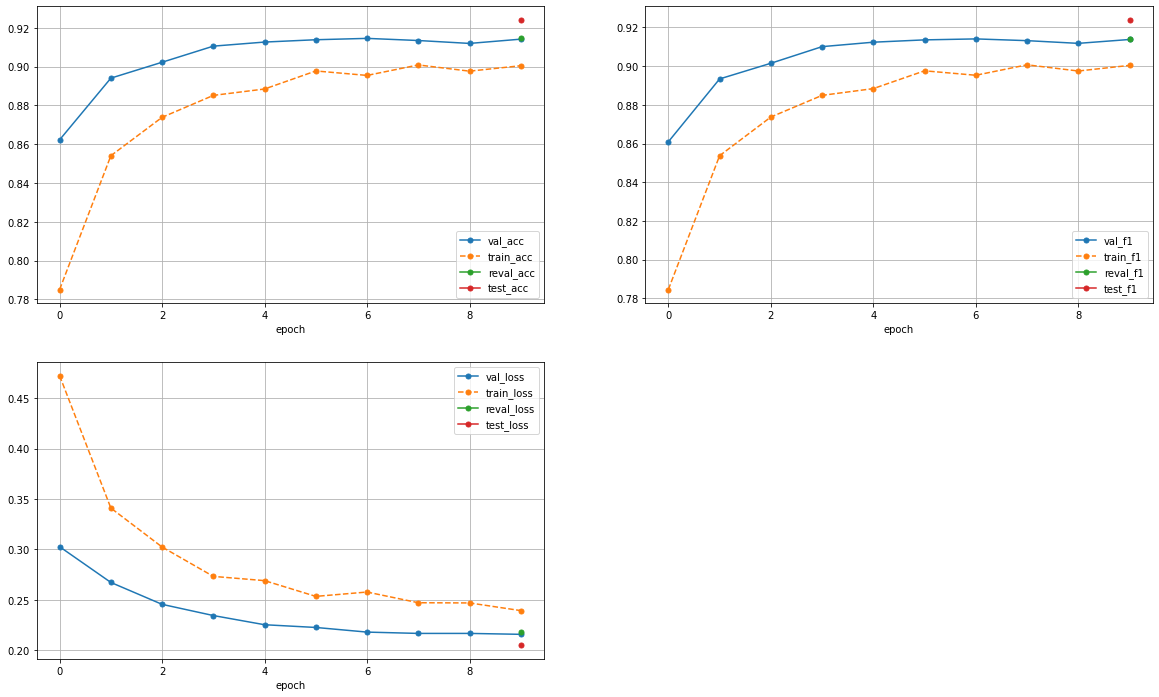

Loaded pretrained weights for efficientnet-b7


Global seed set to 16


Testing: |          | 0/? [00:00<?, ?it/s]

Global seed set to 16


In [35]:
config = CONFIG.copy()
config["model_name"] = "efficientnet-b7"
config["gradient_clip_val"] = 2
best_result = runner.run_single_trial(
    EfficientNetClassifier, config, EXTRA_CONFIG, extra_run_name_prefix="clip-"
)

### ViT fine-tuning

Based on various experiments ViT seem to work betweet without gradient clipping while EfficientNet seems to work better with the gradient clipping turned on.

In [35]:
class ViTClassifier(AFineTunedClassifier):
    def __init__(self, hparams):
        model_name = hparams["model_name"]
        model = pytorch_pretrained_vit.ViT(
            model_name, image_size=IMAGE_SIZE, pretrained=True
        )
        super().__init__(hparams, model)

    def _get_classifier_module_name(self):
        return "fc"

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.
Global seed set to 16
Global seed set to 16


Resized positional embeddings from torch.Size([1, 577, 768]) to torch.Size([1, 145, 768])


Global seed set to 16

  | Name              | Type             | Params
-------------------------------------------------------
0 | model             | ViT              | 86.4 M
1 | criterion         | CrossEntropyLoss | 0     
2 | train_metric_calc | LitMetricsCalc   | 0     
3 | val_metric_calc   | LitMetricsCalc   | 0     
4 | test_metric_calc  | LitMetricsCalc   | 0     
-------------------------------------------------------
86.4 M    Trainable params
0         Non-trainable params
86.4 M    Total params


Loaded pretrained weights.


Validation sanity check: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

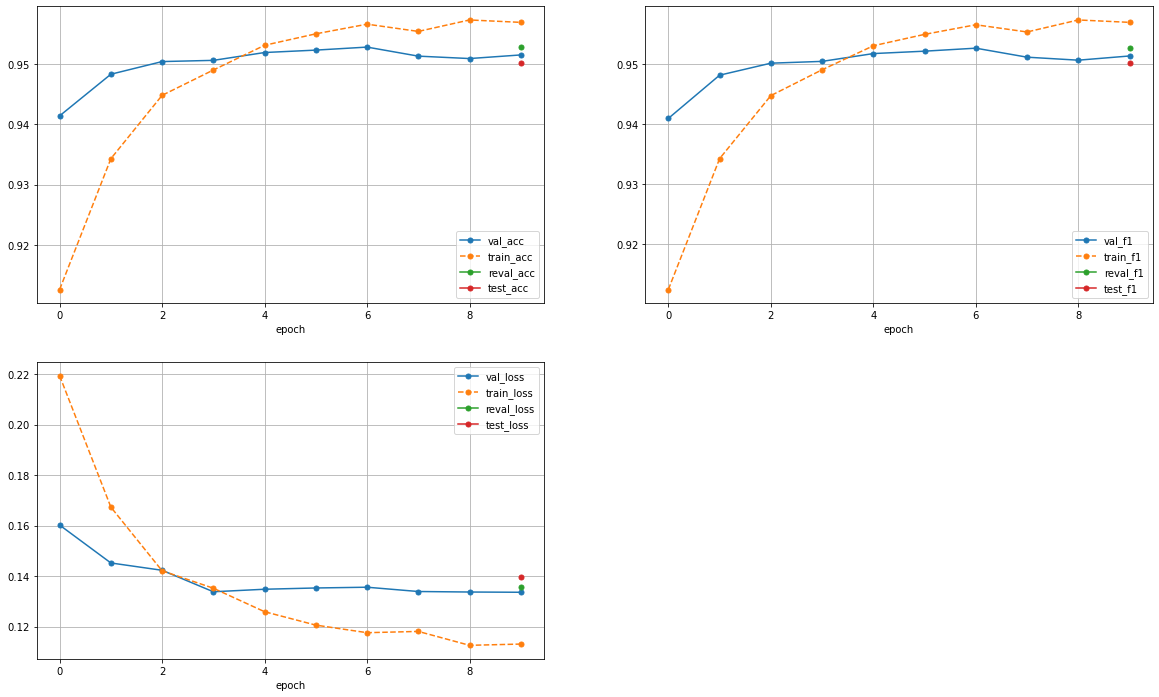

Resized positional embeddings from torch.Size([1, 577, 768]) to torch.Size([1, 145, 768])


Global seed set to 16


Loaded pretrained weights.


Testing: |          | 0/? [00:00<?, ?it/s]

Global seed set to 16


In [34]:
config = CONFIG.copy()
config["model_name"] = "B_16_imagenet1k"
config["gradient_clip_val"] = 0
best_result = runner.run_single_trial(
    ViTClassifier, config, EXTRA_CONFIG, extra_run_name_prefix="noclip-"
)

,test_f1,test_acc,run
11,0.9502,0.9502,noclip-single-trial-ViTClassifier
11,0.9239,0.9241,clip-single-trial-EfficientNetClassifier


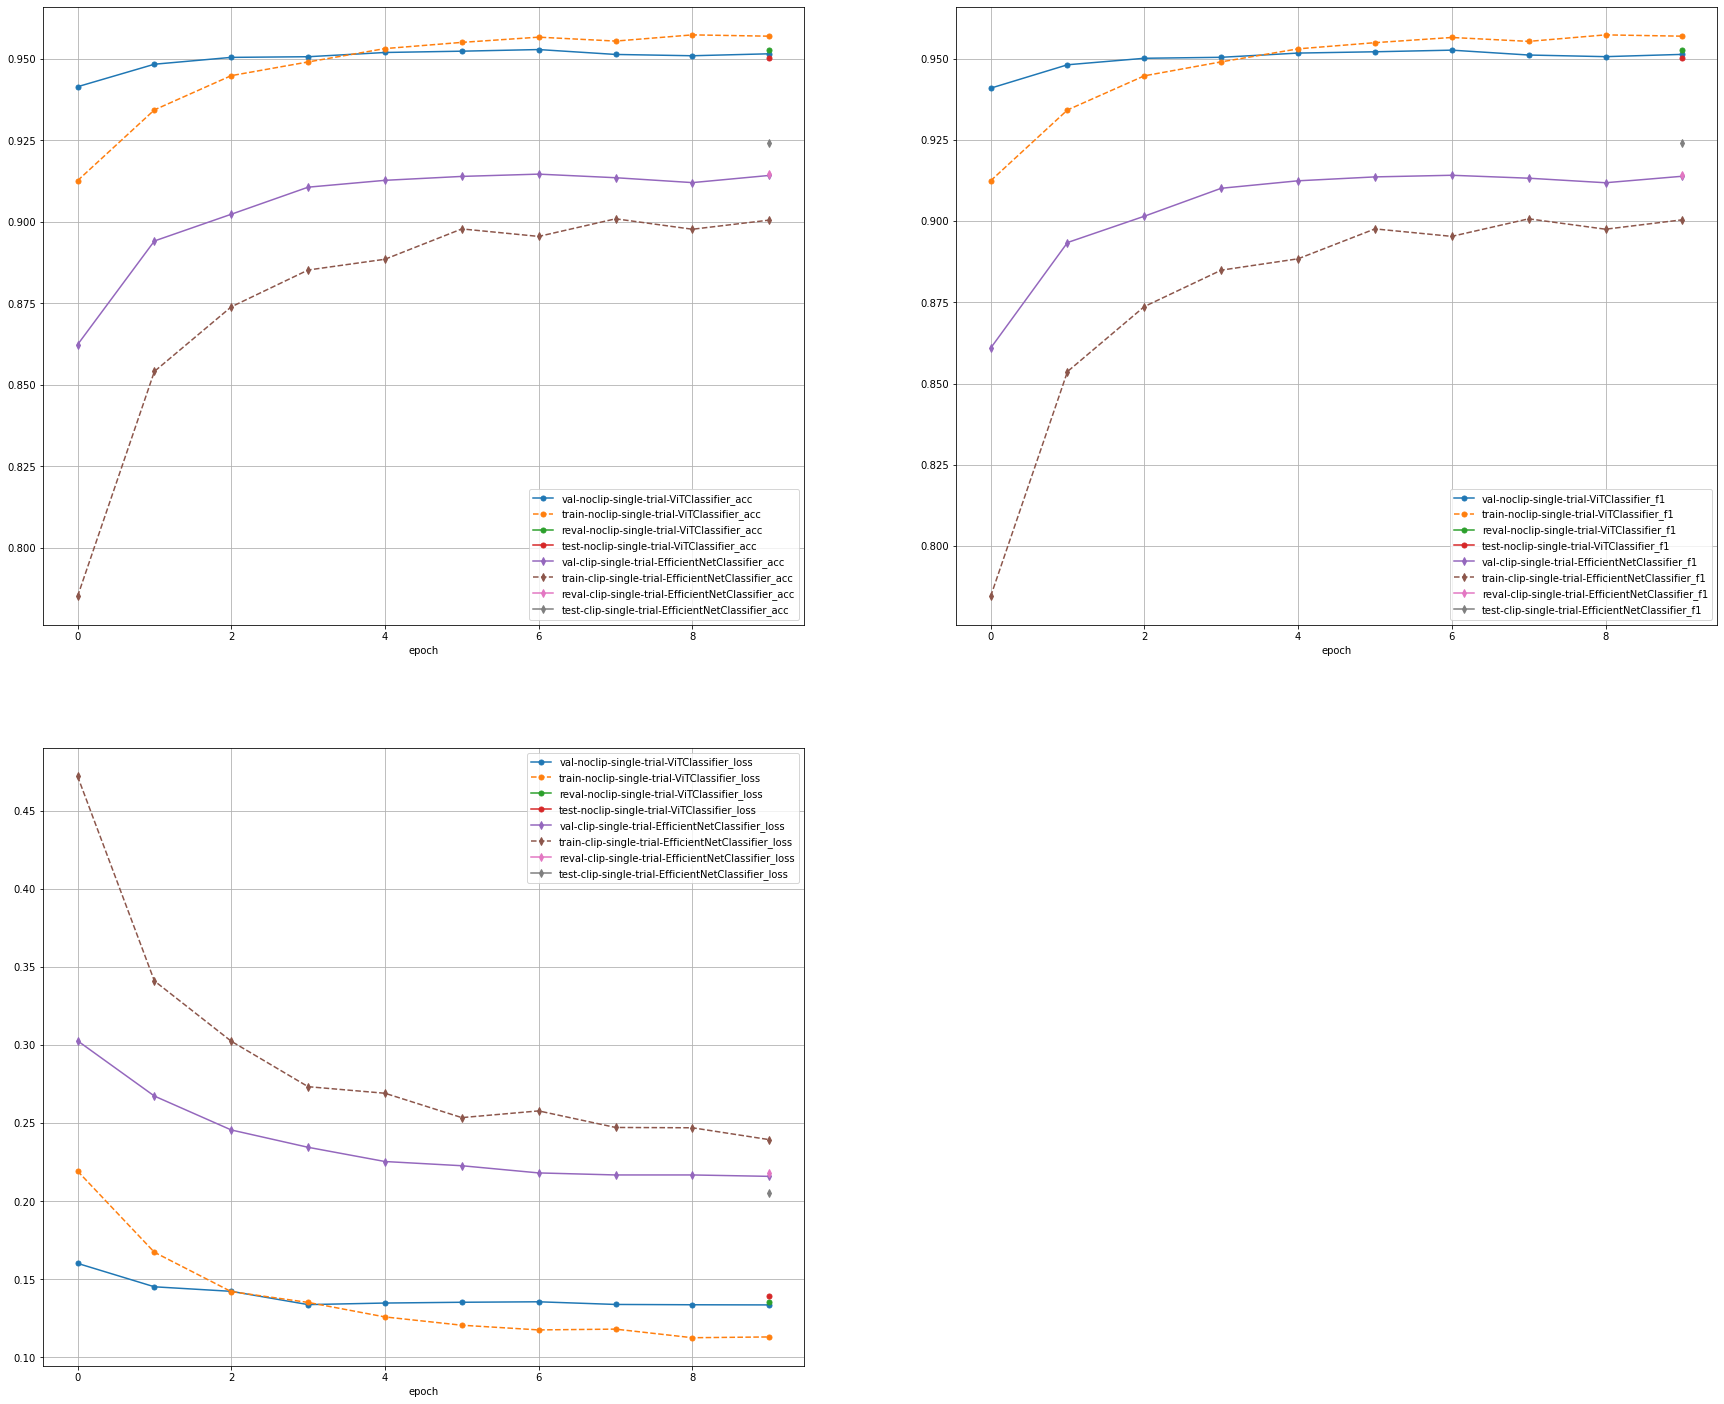

In [36]:
runner.show_metric_report(sort_by_metric_list=["test_f1", "test_acc"], figsize=(30, 25))

### ViT vs EfficientNet: conclusion

1. ViT is approximately 3 times faster than EfficientNet in training (with equal batch sizes) and 4.2 times faster in inference.
2. ViT is more memory efficient (allows for 2 times larger batch sizes) which makes it even more computationally efficient.
3. ViT provides higher accuracy of 95% vs EfficientNet's 92.5% for this particular dataset and hyperparameter values. 

## Attention analysis

ViT implementation from [PyTorch-Pretrained-ViT](https://github.com/lukemelas/PyTorch-Pretrained-ViT) GitHub project contains built-in mechanism to capture the attention scores generated on each of the transformer levels inside "scores" attribute of `MultiHeadedSelfAttention` PyTorch module:

```
class MultiHeadedSelfAttention(nn.Module):
    """Multi-Headed Dot Product Attention"""
    def __init__(self, dim, num_heads, dropout):
        super().__init__()
        self.proj_q = nn.Linear(dim, dim)
        self.proj_k = nn.Linear(dim, dim)
        self.proj_v = nn.Linear(dim, dim)
        self.drop = nn.Dropout(dropout)
        self.n_heads = num_heads
        self.scores = None # for visualization
```        
We will use this "scores" files to extract attention maps from each level.

In [36]:
lmodule = best_result["lmodule_best"]

Resized positional embeddings from torch.Size([1, 577, 768]) to torch.Size([1, 145, 768])
Loaded pretrained weights.


In [43]:
model = lmodule.model.eval()

We will visualize cumulative attention maps calculated as cumulative product of all maps from the first level up to Nth level of the transformer.

In [55]:
def calc_cumulative_attention(input_tensor, model):
    logits = model(input_tensor.unsqueeze(0))

    att_mat_list = [block.attn.scores for block in model.transformer.blocks]

    att_mat = torch.stack(att_mat_list).squeeze(1)

    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=1)

    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1))
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n - 1])

    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    cumul_att_mask_list = []
    # Attention from the output token to the input space.
    for v in joint_attentions:
        att_mask = v[0, 1:].reshape(grid_size, grid_size).detach()
        img_size = input_tensor.shape[1:]
        att_mask_resized = torch.nn.functional.interpolate(
            att_mask.unsqueeze(0).unsqueeze(0), img_size, mode="bilinear"
        )
        cumul_att_mask_list.append(att_mask_resized)
    return cumul_att_mask_list, logits

In [56]:
def show_attention(input_tensor, att_mask):
    att_mask_normalized = att_mask / att_mask.max()
    result = att_mask_normalized * input_tensor
    show_image_tensors(
        [input_tensor, result, att_mask_normalized],
        ["Original", "Attention*Original", "AttentionMap"],
        figsize=(10, 30),
        cmap="gray",
    )

In [84]:
def show_prediction(logits, ind_class_true):
    N_MAX_CLASSES = 5
    label_true = UTKFaces.class_ind2label(ind_class_true)
    probs = torch.nn.Softmax(dim=-1)(logits)
    class_ind_sorted = torch.argsort(probs, dim=-1, descending=True)
    print(f"Real label: {label_true}", end=" | ")
    print("Prediction: ", end="")
    for idx in class_ind_sorted[0, :N_MAX_CLASSES]:
        print(
            f"{UTKFaces.class_ind2label(idx.item())} : {probs[0, idx.item()]:.5f}",
            end=" ",
        )

In [85]:
def show_attentions_and_prediction(
    model, input_interece_tensor, ind_class_true, input_show_tensor, ind_level_list
):
    cumul_att_mask_list, logits = calc_cumulative_attention(
        input_inference_tensor, model
    )
    show_prediction(logits, ind_class_true)
    for ind_level in ind_level_list:
        show_attention(input_show_tensor, cumul_att_mask_list[ind_level])

Let us visialize the cumulative attention for levels 0, 3, 7 and 11 (the last layer) of the transformer

Real label: female | Prediction: female : 0.98817 male : 0.01183 

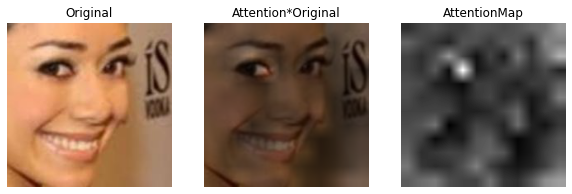

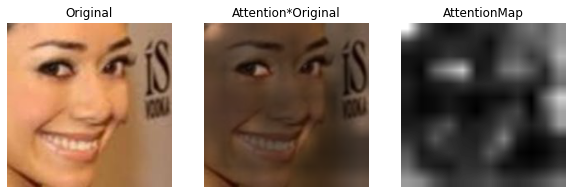

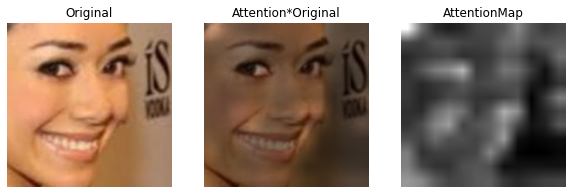

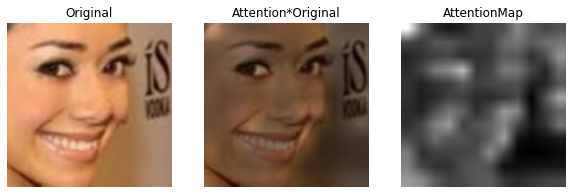

In [86]:
ind = 100
input_inference_tensor = dataset_dict["inference_test_dataset"][ind][0]
input_show_tensor = dataset_dict["show_test_dataset"][ind][0]
ind_class_true = dataset_dict["inference_test_dataset"][ind][1]
show_attentions_and_prediction(
    model, input_inference_tensor, ind_class_true, input_show_tensor, [0, 3, 7, 11]
)

As we can see the attention for the final layers of the transformer becomes more focused on the parts of the face important for gender classification.

Let us now look across all various data samples to see which parts of the face ViT finds important

Real label: female | Prediction: female : 0.98817 male : 0.01183 

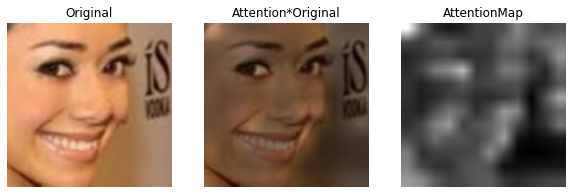

Real label: male | Prediction: male : 0.90847 female : 0.09153 

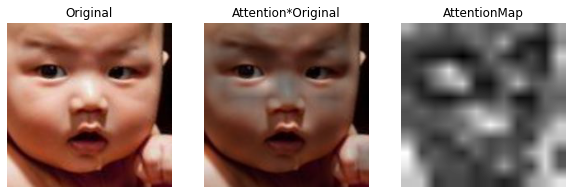

Real label: male | Prediction: male : 0.99929 female : 0.00071 

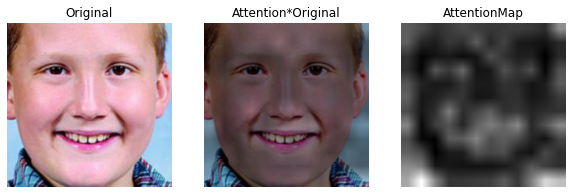

Real label: male | Prediction: male : 0.54686 female : 0.45314 

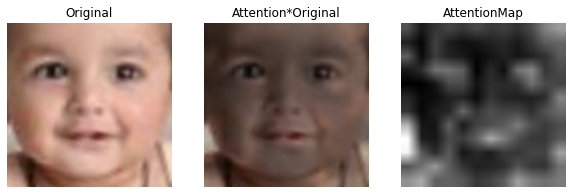

Real label: female | Prediction: female : 0.99148 male : 0.00852 

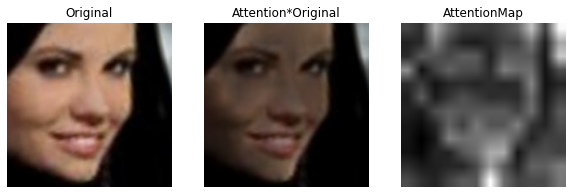

Real label: female | Prediction: female : 0.99398 male : 0.00602 

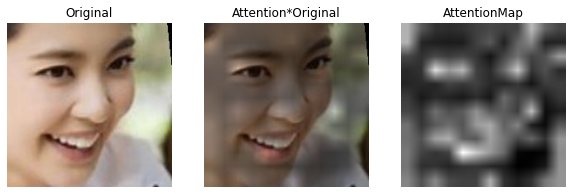

Real label: female | Prediction: female : 0.99826 male : 0.00174 

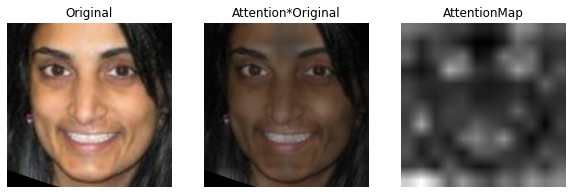

Real label: female | Prediction: female : 0.99523 male : 0.00477 

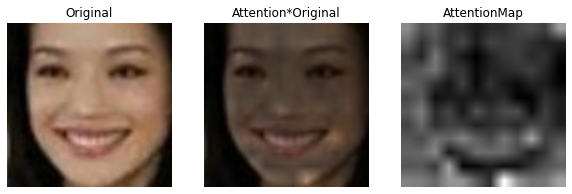

Real label: male | Prediction: male : 0.99657 female : 0.00343 

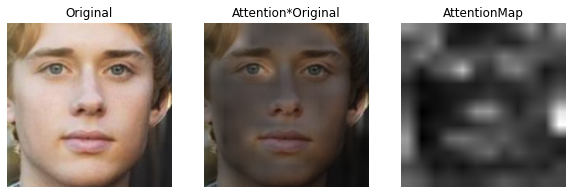

Real label: female | Prediction: female : 0.99552 male : 0.00448 

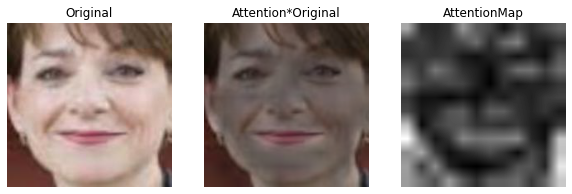

In [88]:
for ind in range(100, 120, 2):
    input_inference_tensor = dataset_dict["inference_test_dataset"][ind][0]
    ind_class_true = dataset_dict["inference_test_dataset"][ind][1]
    input_show_tensor = dataset_dict["show_test_dataset"][ind][0]
    show_attentions_and_prediction(
        model, input_inference_tensor, ind_class_true, input_show_tensor, [11]
    )

### Attention analysis: conclusion

The attention maps shown above provide sufficient ground to say that ViT is good at detecting 
 - the "building blocks" of a face such as eyes, nose, mouths, hair and exactly these face elements ViT finds important
 - face position (as eyes, nose, mouse and face edges are detected regardless of face position and orientation)

## Position embedding analysis

Let us define a few functions for 
 - extracting both image patch and <cls> patch positional embeddings from the model
 - calculating cosine similarity between the embeddings

In [359]:
def extract_patch_and_cls_pos_embedding_mat(model):
    patch_grid_size_list = [
        math.floor(IMAGE_SIZE / s) for s in model.patch_embedding.stride
    ]

    pos_emb_mat = model.positional_embedding.pos_embedding.squeeze(0)

    n_patches = pos_emb_mat.shape[0] - 1

    assert patch_grid_size_list[0] * patch_grid_size_list[1] == n_patches

    patch_pos_emb_mat = pos_emb_mat[1:, :]
    cls_pos_emb = pos_emb_mat[0:1, :]
    return patch_pos_emb_mat, cls_pos_emb, patch_grid_size_list

In [360]:
def sim_matrix(a, b, eps=1e-8):
    # Cosine similarity
    """
    added eps for numerical stability
    """
    a_n, b_n = a.norm(dim=1)[:, None], b.norm(dim=1)[:, None]
    a_norm = a / torch.max(a_n, eps * torch.ones_like(a_n))
    b_norm = b / torch.max(b_n, eps * torch.ones_like(b_n))
    sim_mt = torch.mm(a_norm, b_norm.transpose(0, 1))
    return sim_mt

In [361]:
def calc_embedding_cossim_grid(patch_pos_emb_mat, patch_grid_size_list):
    patch_pos_emb_sim_mat = sim_matrix(patch_pos_emb_mat, patch_pos_emb_mat)

    patch_pos_emb_sim_mat.max()
    n_patches = patch_grid_size_list[0] * patch_grid_size_list[1]
    grid_tensor = torchvision.utils.make_grid(
        patch_pos_emb_sim_mat.reshape([n_patches, 1] + patch_grid_size_list),
        nrow=patch_grid_size_list[0],
    ).detach()
    #
    # torchvision.utils.make_grid always generates RGB image
    # even if number of color channges in the input images is 1
    # in such cases we can safely ignore all color channels but the first one
    # because they are all equal:
    #
    assert torch.allclose(grid_tensor[0, :, :], grid_tensor[1, :, :])
    assert torch.allclose(grid_tensor[0, :, :], grid_tensor[2, :, :])
    #
    return grid_tensor[0:1, :, :]

In [362]:
def get_patch_pos_embedding_cossim_grid(model):
    patch_pos_emb_mat, cls_pos_emb, patch_grid_size_list = extract_patch_and_cls_pos_embedding_mat(model)
    grid_sim_mat = calc_embedding_cossim_grid(patch_pos_emb_mat, patch_grid_size_list)
    return grid_sim_mat

In [363]:
grid_sim_fine_tuned_mat = get_patch_pos_embedding_cossim_grid(model)

In [364]:
model_orig_pretrained = pytorch_pretrained_vit.ViT(
    "B_16_imagenet1k", image_size=IMAGE_SIZE, pretrained=True
)

Resized positional embeddings from torch.Size([1, 577, 768]) to torch.Size([1, 145, 768])
Loaded pretrained weights.


In [365]:
grid_orig_pretrained_mat = get_patch_pos_embedding_cossim_grid(model_orig_pretrained)

In [366]:
grid_sim_diff_mat = grid_sim_fine_tuned_mat - grid_orig_pretrained_mat

Let us estimate the magnitude of values inside `grid_sim_diff_mat`

In [367]:
max_rel_diff = (
    2
    * grid_sim_diff_mat.abs().max()
    / (grid_sim_fine_tuned_mat.abs().mean() + grid_orig_pretrained_mat.abs().mean())
)
print(
    f"Maximum relative percentage difference between original pre-trained and fine-tuned embeddings: {max_rel_diff*100: .3f}%"
)

Maximum relative percentage difference between original pre-trained and fine-tuned embeddings:  0.975%


As we can see the maximum absolute difference between the two embeddings is less than 1% of the average level of both the original pre-trained and fine-tuned positional embeddings

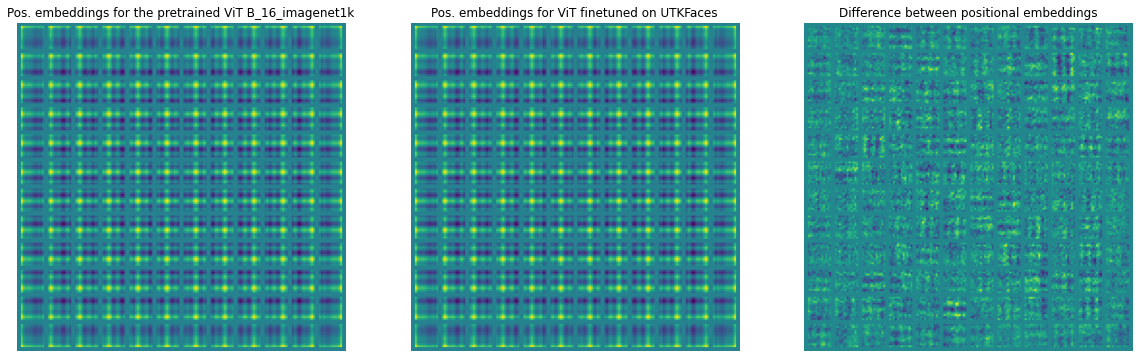

In [368]:
show_image_tensors(
    [
        grid_orig_pretrained_mat,
        grid_sim_fine_tuned_mat,
        grid_sim_diff_mat,
    ],
    [
        "Pos. embeddings for the pretrained ViT B_16_imagenet1k",
        "Pos. embeddings for ViT finetuned on UTKFaces",
        "Difference between positional embeddings",
    ],
    figsize=(20, 20),
)

The graps above show that the differences are not systematic. This, combined with the low value of relative difference between the original pre-trained and fine-tuned embeddings allows to conclude that the positional information inside the positional embeddings is preserved during the fine-tuning process.

## References

[1] "Attention Is All You Need", Ashish Vaswani and Noam Shazeer and Niki Parmar and Jakob Uszkoreit and Llion Jones and Aidan N. Gomez and Lukasz Kaiser and Illia Polosukhin,
      2017,
      [arXiv/1706.03762](https://arxiv.org/abs/1706.03762)
    
[2] "EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks", Mingxing Tan and Quoc V. Le, 2020,  [arXiv/1905.11946](https://arxiv.org/abs/1905.11946)

[3]. "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale", Alexey Dosovitskiy and Lucas Beyer and Alexander Kolesnikov and Dirk Weissenborn and Xiaohua Zhai and Thomas Unterthiner and Mostafa Dehghani and Matthias Minderer and Georg Heigold and Sylvain Gelly and Jakob Uszkoreit and Neil Houlsby, 2020, [arXiv/2010.11929](https://arxiv.org/abs/2010.11929)

[4] [Vision Transformer](https://github.com/google-research/vision_transformer) GitHub repo with original implementation of Vision Transformer in Jax by Google

[5]  [EfficientNet-PyTorch](https://github.com/lukemelas/EfficientNet-PyTorch) GitHub project

[6] [PyTorch-Pretrained-ViT](https://github.com/lukemelas/PyTorch-Pretrained-ViT) GitHub project